# Estudio de resultados

En este notebook, se muestran las métricas obtenidas para los diferentes modelos evaluados mediante el dataset Household Power Consumption del portal UCI (https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption). El objetivo es estudiar el impacto de diferentes estrategias de encoding para ver cuál nos permite obtener mejores resultados en secuencias de larga extensión.

Examinaremos las siguientes alternativas:
- Uso de estadísticos básicos: media, std, min y max.
- Uso de estadísticos + lags anteriores mediante ventana.
- Uso de SPE
- Uso de SPE + otros encodings absolutos
- Estudio ponderado de PE varios
- Estudio ponderado sin normalizar
- Informer Original
- Uso de TPE

Tras dichas pruebas, examinaremos la mejor alternativa en base a las métricas y el costo computacional, y probaremos a experimentar si realmente la información añadida tiene impacto en la calidad de los resultados realizando Shuffle del contexto de entrada del encoder en test.

## Evaluación de los 8 modelos de PE

Comenzaremos experimentando primero cuál de las 8 alternativas propuestas permite obtener un mejor resultados. En muchas de ellas, como ya se comentaba, se utilizan diversas estrategias de encoding ponderadas, ya que así el modelo puede decidir cuál de ellas es la que mejor se adapta al problema. Esto se debe a que, en ocasiones, la coexistencia de varios métodos no tiene por qué empeorar el resultado, ya que cada problema requiere unas necesidades específicas, en función de la correlación de los datos, y no existe una codificación de PE absoluta mejor en todos los casos.

A continuación, procederemos a la lectura de los ficheros csv que contienen los resultados, y compararemos tanto en tabla como gráficamente sus resultados. Nos fijaremos especialmente en MAE Y MSE, recurriendo al resto de métricas cuando no exista una diferencia clara.

In [22]:
import pandas as pd

# Ficheros con sus nombres de modelo
model_files = {
    "HPC_ALL_PE_v2": "../Resultados/HPC_ALL_PE_v2.csv",
    "HPC_ALL_PE_v2_NoNorm": "../Resultados/HPC_ALL_PE_v2_NoNorm.csv",
    "HPC_Orig": "../Resultados/HPC_Orig.csv",
    "HPC_SPE": "../Resultados/HPC_SPE.csv",
    "HPC_SPE_ALL": "../Resultados/HPC_SPE_ALL.csv",
    "HPC_Stats_Only": "../Resultados/HPC_Stats_Only.csv",
    "HPC_TPE": "../Resultados/HPC_TPE.csv",
    "HPC_Ventana_NoLags": "../Resultados/HPC_Ventana_NoLags.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo
    # Pivotar: cada métrica será una columna, el modelo será el índice
    df_pivot = df.pivot(index='Modelo', columns='Métrica', values='Valor')
    dfs.append(df_pivot)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice si quieres "Modelo" como columna normal
final_df.reset_index(inplace=True)
final_df.sort_values(by="MSE")

display(final_df)


Métrica,Modelo,MAE,MAPE,MSE,MSPE,RMSE,TestTime(s),TrainTime(s)
0,HPC_ALL_PE_v2,0.382510,2.314417,0.469697,978.416911,0.685310,337.828113,21460.416289
1,HPC_ALL_PE_v2_NoNorm,0.393849,2.240669,0.473760,954.817383,0.688295,NaN,NaN
2,HPC_Orig,0.402445,2.602580,0.525711,1374.003215,0.725016,113.442166,8618.726252
3,HPC_SPE,0.417545,2.518025,0.553648,1348.892415,0.743617,1461.875124,111056.220972
4,HPC_SPE_ALL,0.441418,2.558296,0.582600,1388.203491,0.762703,1730.330627,131450.338871
5,HPC_Stats_Only,0.399005,2.291084,0.488370,973.201518,0.698823,NaN,NaN
6,HPC_TPE,0.378166,2.361141,0.469160,1125.801351,0.684904,NaN,NaN
7,HPC_Ventana_NoLags,0.375908,2.286222,0.469156,1014.750834,0.684949,NaN,NaN


Podemos apreciar que el modelo con mejor rendimiento es el basado en varios encodings posicionales los cuales han sido normalizados y ponderados con pesos entre 0 y 1 mediante SoftMax. Son los que mejores resultados ofrecen en MSE, pero también está dentro del top cuando observamos MAE o RMSE, pero ahí si existen leves mejoras en otros modelos. Sin embargo, dado a la cercanía de estas otras alternativas, y a su mayor coste computacional, podríamos considerar que el modelo propuesto en la primera fila es aquel que debemos comparar y verificar con respecto al modelo original.

Para ver los resultados de forma gráfica, podemos representar los valores de MSE y MAE en un gráfico de barras.

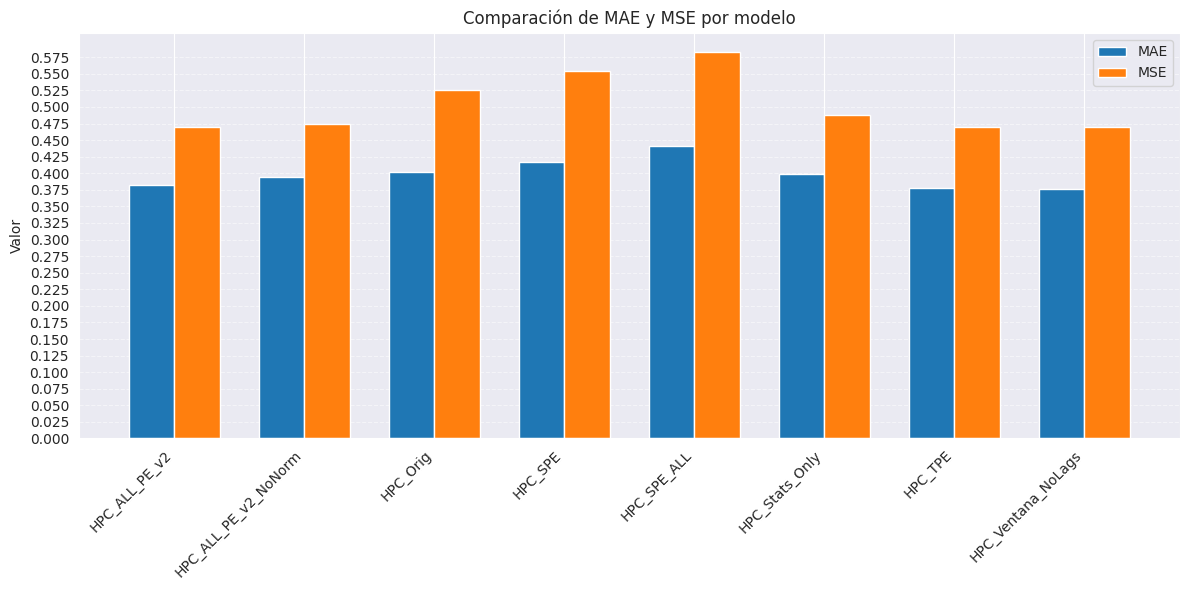

In [29]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['MAE', 'MSE']
df_plot = final_df[['Modelo'] + metricas]

# Configurar el gráfico
x = df_plot['Modelo']
x_pos = range(len(x))
width = 0.35  # ancho de las barras

# Crear las barras
fig, ax = plt.subplots(figsize=(12, 6))

# Barras para MAE
ax.bar([p - width / 2 for p in x_pos], df_plot['MAE'], width=width, label='MAE')

# Barras para MSE
ax.bar([p + width / 2 for p in x_pos], df_plot['MSE'], width=width, label='MSE')

# Etiquetas y leyenda
ax.set_xticks(x_pos)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_yticks(np.arange(0, .6, 0.025))
ax.set_ylabel('Valor')
ax.set_title('Comparación de MAE y MSE por modelo')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Comparativa del mejor modelo con Informer original